In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('large_repr', 'truncate')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns


from pathlib import Path

from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from typing import Tuple

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
sns.set_palette(colours)
%matplotlib inline

In [3]:
import sys
sys.path.insert(0, '../src')
from ds_toolbox import create_balanced_dataset, plot_confusion_matrix_with_labels, compute_metrics

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
DATA_PATH = Path("../data/")
DOCUMENTATION_PATH = Path("../documentation")
RANDOM_STATE_PARAMETER = 42
TEST_SIZE = .25

In [6]:
data = pd.read_csv(DATA_PATH / "apld_patients.csv")
data.reset_index(inplace=True)
data.drop(["BC_PATIENT", "SN_PATIENT", "DIAGNOSIS_CODE", "index"], axis=1, inplace=True)
data.rename(columns={"SERVICE_DATE_y": "Service_date", "SEASON": "Season"}, inplace=True)
cols = ['PATIENT_ID',
 'Service_date',
 'Season',
 'PRC_STD_CD',
 'Blood',
 'Bone',
 'Breast',
 'Heart',
 'Lungs',
 'Medication',
 'Medication ',
 'Other',
 'Skin',
 'Stomach',
 'Vagina',
  'mBC_PATIENT']
data = data[cols]
data = pd.concat([data.iloc[:,:10], data.iloc[:, 11:]], axis=1)
data.head()

,PATIENT_ID,Service_date,Season,PRC_STD_CD,Blood,Bone,Breast,Heart,Lungs,Medication,Other,Skin,Stomach,Vagina,mBC_PATIENT
0,134290358,10/15/2015,4,99214,0,0,0,0,0,0,1,0,0,0,True
1,134290358,10/15/2015,4,99214,0,0,0,0,0,0,1,0,0,0,True
2,134290358,10/15/2015,4,99214,0,0,0,0,0,0,1,0,0,0,True
3,1057559593,11/25/2015,4,85025,0,0,0,0,0,0,1,0,0,0,True
4,1057559593,11/25/2015,4,36415,0,0,0,0,0,0,1,0,0,0,True


In [7]:
data.columns

Index(['PATIENT_ID', 'Service_date', 'Season', 'PRC_STD_CD', 'Blood', 'Bone',
       'Breast', 'Heart', 'Lungs', 'Medication', 'Other', 'Skin', 'Stomach',
       'Vagina', 'mBC_PATIENT'],
      dtype='object')

In [16]:
FEATURES = ['Season', 'Medication', 'Blood', 'Bone',
       'Breast', 'Heart', 'Lungs',  
       'Skin', 'Stomach', 'Vagina', 'Other', 'mBC_PATIENT']
model_data = data[FEATURES]
ohe = pd.get_dummies(model_data.Season, prefix="Season")
model_data = pd.concat([model_data, ohe], axis=1)
le = LabelEncoder()
model_data["mBC_PATIENT"] = le.fit_transform(model_data["mBC_PATIENT"])
model_data = model_data[["Blood", 'Bone',
       'Breast', 'Heart', 'Lungs','Other', 'Skin', 'Stomach',
       'Vagina',  'Medication', "Season_1", "Season_2", "Season_3", "Season_4", "mBC_PATIENT"]]
model_data.head()

,Blood,Bone,Breast,Heart,Lungs,Other,Skin,Stomach,Vagina,Medication,Season_1,Season_2,Season_3,Season_4,mBC_PATIENT
0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1


In [17]:
x_train, x_test, y_train, y_test = train_test_split(
        model_data.iloc[:,:-1],
        model_data.iloc[:,-1].values.ravel(),
        random_state = RANDOM_STATE_PARAMETER,
        test_size=TEST_SIZE,
    )            

# Random forest classifier 

In [18]:
rf = RandomForestClassifier()      
rf = rf.fit(x_train.values,y_train)
y_prediction = rf.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")

accuracy:0.6086765887998441, sensitivity:0.8248325181866755, specificity:0.2941633775864131


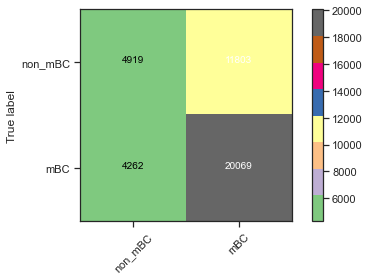

In [19]:
plot_confusion_matrix_with_labels(x_test, y_test, rf, ["non_mBC", "mBC"], filename="random_forest.pdf")

# Logistic Regression

In [35]:
%%time
model = LogisticRegression(class_weight='balanced')
tuning_parameters = {
    'C':[1e-4,1e-3,1e-2,0.1,1],
    "max_iter": [2000, 3000, 4000, 5000]
}

lr_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 5, n_jobs=4,
                              random_state = 20)
lr_search.fit(x_train.values, y_train)
print('Best parameters:', lr_search.best_params_)
best_lr_model = lr_search.best_estimator_
y_prediction = best_lr_model.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")

Best parameters: {'max_iter': 4000, 'C': 0.01}
accuracy:0.5787396779772489, sensitivity:0.5138711931281081, specificity:0.6731252242554718
CPU times: user 1.45 s, sys: 189 ms, total: 1.64 s
Wall time: 3.73 s


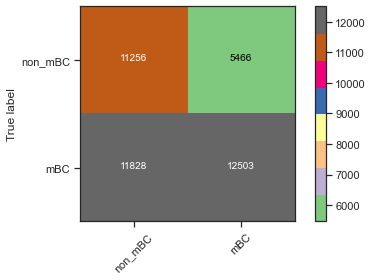

In [32]:
plot_confusion_matrix_with_labels(x_test, y_test, best_lr_model, ["non_mBC", "mBC"], filename="logistic_reg.pdf")

accuracy:0.6086522300440893, sensitivity:0.8248325181866755, specificity:0.2941035761272575


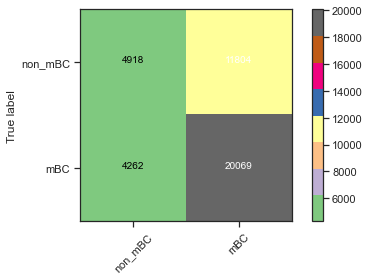

In [22]:
xgb = XGBClassifier(random_state = RANDOM_STATE_PARAMETER, n_jobs = -1)
xgb.fit(x_train, y_train)
y_prediction = xgb.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")
plot_confusion_matrix_with_labels(x_test, y_test, xgb, ["non_mBC", "mBC"], filename="xgb.pdf")

In [23]:
mbc_ratio=y_train[y_train == 1].shape[0]/y_train[y_train == 0].shape[0]
mbc_ratio

1.4568014522531867

# Logistic Regression on oversampled data

In [24]:
X_sampled, y_sampled = create_balanced_dataset('SMOTE', x_train, y_train)

X=(123157, 14), y=[(0, 50129), (1, 73028)]
X_sampled=(146056, 14), y_sampled=[(0, 73028), (1, 73028)]


In [25]:
X_sampled.head()

,Blood,Bone,Breast,Heart,Lungs,Other,Skin,Stomach,Vagina,Medication,Season_1,Season_2,Season_3,Season_4
0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,1


# Random Forest on oversampled data

In [26]:
oversampling_rf = RandomForestClassifier()      
oversampling_rf = oversampling_rf.fit(X_sampled, y_sampled)
y_prediction = oversampling_rf.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")

accuracy:0.5786666017099846, sensitivity:0.5136245941391641, specificity:0.6733046286329386


In [27]:
oversampling_xgb = XGBClassifier(random_state = RANDOM_STATE_PARAMETER, n_jobs = -1)
oversampling_xgb.fit(X_sampled, y_sampled)
y_prediction = oversampling_xgb.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")

accuracy:0.5786666017099846, sensitivity:0.5136245941391641, specificity:0.6733046286329386


In [38]:
%%time
model = LogisticRegression()
#model = LogisticRegression(class_weight='balanced')
tuning_parameters = {
    'C':[2, 5, 10],
    "max_iter": [2000, 3000, 4000, 5000]
}

lr_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 5, n_jobs=4,
                              random_state = 20)
lr_search.fit(X_sampled, y_sampled)
print('Best parameters:', lr_search.best_params_)
oversampling_best_lr_model = lr_search.best_estimator_
y_prediction = oversampling_best_lr_model.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")

Best parameters: {'max_iter': 5000, 'C': 5}
accuracy:0.5785691666869657, sensitivity:0.5135834943076734, specificity:0.6731252242554718
CPU times: user 5.82 s, sys: 619 ms, total: 6.44 s
Wall time: 13 s


In [29]:
y_prediction = oversampling_best_lr_model.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")

accuracy:0.5787396779772489, sensitivity:0.5138711931281081, specificity:0.6731252242554718


In [30]:
y_prediction = oversampling_rf.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")

accuracy:0.5786666017099846, sensitivity:0.5136245941391641, specificity:0.6733046286329386
